# Sentiment Analysis with Deep Learning

On various NLP tasks neural-based models achieve superior results compared to traditional machine learning models like SVM or logistic regression. Let's use prepared word vectors (BOW, TF-IDF and Word2Vec) to test their performance with neural networks.

There will be used three different types of deep neural networks:
* Densely Connected Neural Network
* RNN - Recurrent Neural Network (with LSTM - Long Short Term Memory Network)
* CNN - Convolutional Neural Network

As a baseline, let's use the best result achieved so far: accuracy - 95,8% and f1-score - 0,9774 for Logistic Regression with TF-IDF word embeddings.

\* This notebook was created in Colab

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from keras import models, layers, metrics, regularizers

In [2]:
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Colab Notebooks/nlp_toys_reviews'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_toys_reviews


In [3]:
def load_pickle(path):
  with open(path, 'rb') as handle:
    return pickle.load(handle)

def f1_score(precision, recall):
  return (2 * precision * recall) / (precision + recall)

def unpack_history(history):
  history_dict = {k: np.array(v) for k,v in history.history.items()}
  history_dict['f1'] = f1_score(history_dict['precision'], history_dict['recall'])
  history_dict['val_f1'] = f1_score(history_dict['val_precision'], history_dict['val_recall'])

  epochs = range(1,len(history_dict['accuracy'])+1)

  return history_dict, epochs

def highest_score(metric, metric_name):
  highest_score = [i for i, j in enumerate(metric) if j == max(metric)][0]
  print('The highest %s score in %d epoch: %f' % (metric_name, highest_score+1, metric[highest_score]))

def plot_acc_and_f1(accuracy_train, accuracy_val, f1_train, f1_val, epochs):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

  sns.scatterplot(x=epochs, y=accuracy_train, ax=ax1, label='train')
  sns.lineplot(x=epochs, y=accuracy_val, ax=ax1, label='test')
  ax1.set_title('Train and test accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')

  sns.scatterplot(x=epochs, y=f1_train, ax=ax2, label='train')
  sns.lineplot(x=epochs, y=f1_val, ax=ax2, label='test')
  ax2.set_title('Train and test F1 score')
  ax2.set_ylabel('F1')
  ax2.set_xlabel('epoch')

  plt.tight_layout()
  plt.legend()
  plt.show()

def model_report(history):
  history_dict, epochs = unpack_history(history)

  plot_acc_and_f1(history_dict['accuracy'], history_dict['val_accuracy'], history_dict['f1'], history_dict['val_f1'], epochs)

  highest_score(history_dict['val_accuracy'], 'accuracy')
  highest_score(history_dict['val_f1'], 'f1')

In [4]:
y = np.array(load_pickle('data/sentiment_100k.pickle'))
metrics_definition = ['accuracy', metrics.Precision(), metrics.Recall()]

## Densely Connected NN with Bag of Words Vectors

This simple neural network with BOW word vectors gives slightly better results than the baseline. The optimal solution is to train the model for 5 epochs.

In [5]:
X = load_pickle('data/M_bow_100k.pickle').toarray()

In [6]:
model_bow = models.Sequential()
model_bow.add(layers.Dense(16, activation='relu', input_shape=(X.shape[1],)))
model_bow.add(layers.Dense(16, activation='relu'))
model_bow.add(layers.Dense(1, activation='sigmoid'))

model_bow.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

history_bow = model_bow.fit(X, y,
                            epochs=30,
                            batch_size=256,
                            validation_split=0.33,
                            verbose=0)

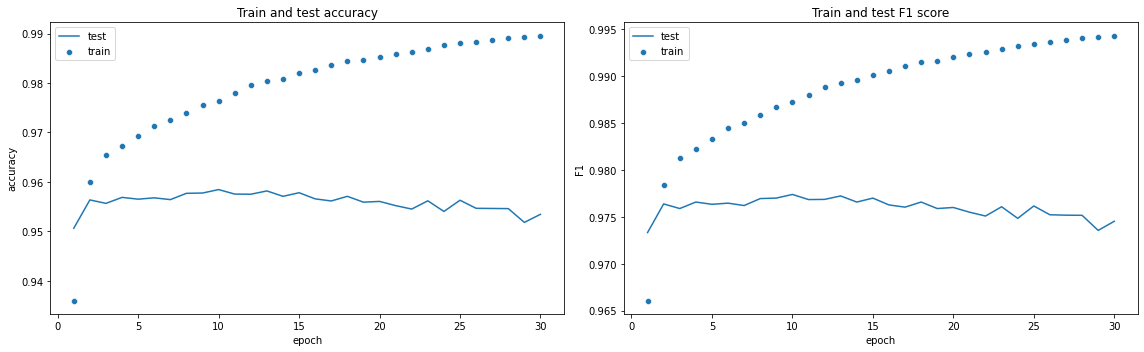

The highest accuracy score in 10 epoch: 0.958455
The highest f1 score in 10 epoch: 0.977391


In [7]:
model_report(history_bow)

## Densely Connected NN with TF-IDF Word Vectors

Combination of simple neural network with TF-IDF word vectors doesn't show any improvement compared to the baseline. Model performance can be improved by eg changing number and size of layers but results still are at the similar level.

In [8]:
X = load_pickle('data/M_tfidf_100k.pickle').toarray()

In [9]:
model_tfidf = None

model_tfidf = models.Sequential()
model_tfidf.add(layers.Dense(32, activation='relu', input_shape=(X.shape[1],)))
model_tfidf.add(layers.Dense(32, activation='relu'))
model_tfidf.add(layers.Dense(1, activation='sigmoid'))

model_tfidf.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

history_tfidf = model_tfidf.fit(X, y,
                                epochs=30,
                                batch_size=512,
                                validation_split=0.33,
                                verbose=0)

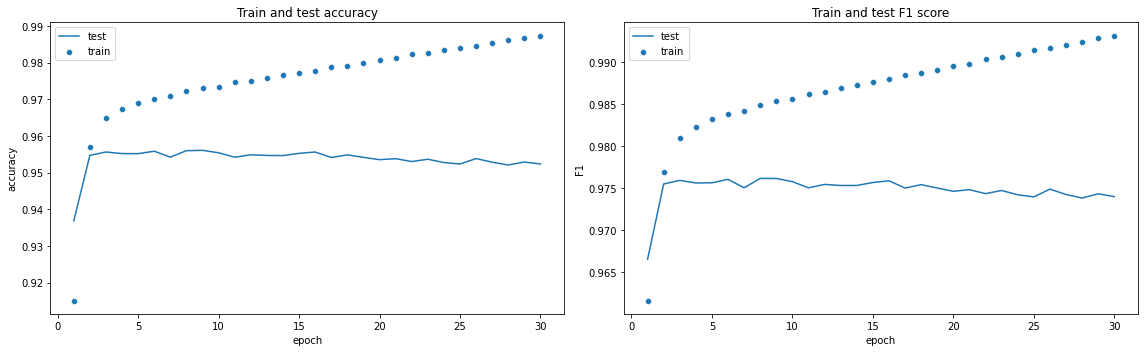

The highest accuracy score in 9 epoch: 0.956061
The highest f1 score in 8 epoch: 0.976117


In [10]:
model_report(history_tfidf)

## Densely Connected NN with Word2Vec Embeddings

It takes 16 epochs to achieve the best results with this simple neural network and Word2Vec word vectors. Compared to the baseline, there is no improvement.

In [11]:
X = load_pickle('data/M_word2vec_100k.pickle')

In [12]:
model_w2v = None

model_w2v = models.Sequential()
model_w2v.add(layers.Dense(64, activation='relu', input_shape=(X.shape[1],)))
model_w2v.add(layers.Dense(32, activation='relu'))
model_w2v.add(layers.Dense(1, activation='sigmoid'))

model_w2v.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

history_w2v = model_w2v.fit(X, y,
                            epochs=30,
                            batch_size=256,
                            validation_split=0.33,
                            verbose=0)

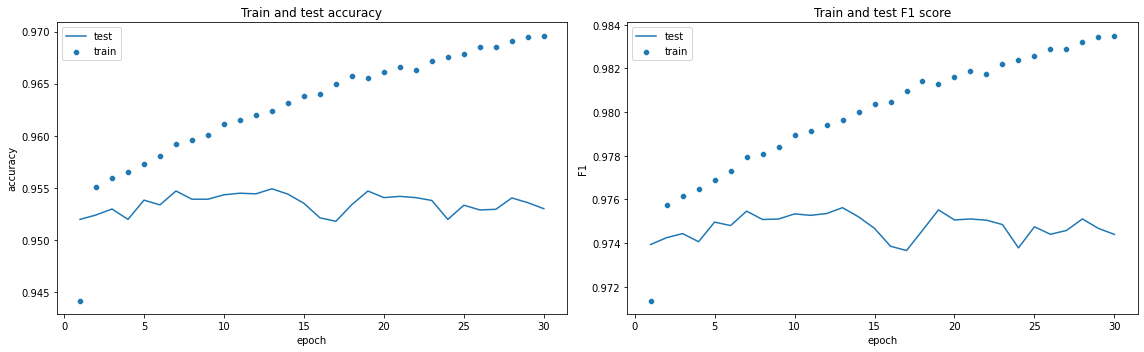

The highest accuracy score in 13 epoch: 0.954909
The highest f1 score in 13 epoch: 0.975623


In [13]:
model_report(history_w2v)

## Long Short Term Memory (LSTM) Network for Sentiment Analysis

LSTM model is a recurrent neural network (RNN) architecture that processes the entire sequence of data, not only a single point (as in the standard feed-forward neural networks).

In this script, word embeddings are trained from text as a part of the model. It is a simple LSTM architecture that produces slightly better result than the baseline.

In [14]:
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop

In [15]:
reviews_ind = load_pickle('data/reviews_ind_100k.pickle')

In [16]:
reviews_length = [len(r) for r in reviews_ind]
print('Average review length: %0.2f, Standard deviation of reviews\'s length: %0.2f' % (np.mean(reviews_length), np.std(reviews_length)))

Average review length: 16.97, Standard deviation of reviews's length: 27.77


In [17]:
from keras.preprocessing import sequence

max_features = 6000
max_len = 50

reviews_ind = [[ind for ind in text_ind if ind < max_features] for text_ind in reviews_ind]
reviews_pad = sequence.pad_sequences(reviews_ind, maxlen=max_len)

X = np.stack(reviews_pad)

print('reviews shape:', reviews_pad.shape)

reviews shape: (100000, 50)


In [18]:
model_lstm = None

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

history_lstm = model_lstm.fit(X, y,
                        epochs=10,
                        batch_size=128,
                        validation_split=0.2)


Epoch 1/10
625/625 [==============================] - 21s 33ms/step - loss: 0.1801 - accuracy: 0.9356 - precision: 0.9493 - recall: 0.9879 - val_loss: 0.1348 - val_accuracy: 0.9521 - val_precision: 0.9638 - val_recall: 0.9845
Epoch 2/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1158 - accuracy: 0.9580 - precision: 0.9696 - recall: 0.9849 - val_loss: 0.1216 - val_accuracy: 0.9566 - val_precision: 0.9680 - val_recall: 0.9850
Epoch 3/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1056 - accuracy: 0.9617 - precision: 0.9722 - recall: 0.9864 - val_loss: 0.1210 - val_accuracy: 0.9567 - val_precision: 0.9725 - val_recall: 0.9802
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.0995 - accuracy: 0.9643 - precision: 0.9741 - recall: 0.9872 - val_loss: 0.1171 - val_accuracy: 0.9584 - val_precision: 0.9658 - val_recall: 0.9894
Epoch 5/10
625/625 [==============================] - 19s 31ms/step - loss: 0.0948 - accuracy: 0

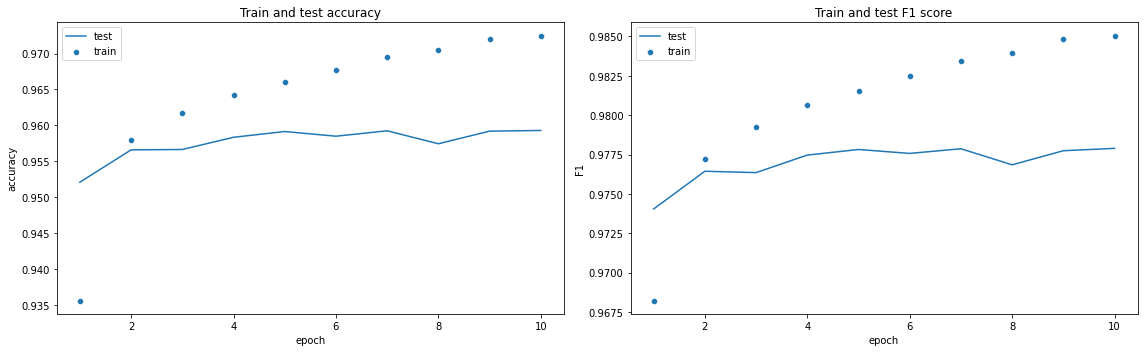

The highest accuracy score in 10 epoch: 0.959300
The highest f1 score in 10 epoch: 0.977891


In [19]:
model_report(history_lstm)

## Convolutional Neural Network (CNN) for Sentiment Analysis

CNNs are the core of most Computer Vision systems today but using them in NLP problems gives some interesting results as well.

Although this model is more complex than the ones above, it doesn't outperform the previous ones.

In [20]:
model_conv = None

model_conv = Sequential()
model_conv.add(layers.Embedding(max_features, 128, input_length=max_len))
model_conv.add(layers.Conv1D(32, 7, activation='relu'))
model_conv.add(layers.MaxPooling1D(5))
model_conv.add(layers.Conv1D(32, 7, activation='relu'))
model_conv.add(layers.GlobalMaxPooling1D())
model_conv.add(layers.Dense(1, activation='sigmoid'))
model_conv.summary()

model_conv.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

history_conv = model_conv.fit(X, y,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.33)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           768000    
_________________________________________________________________
conv1d (Conv1D)              (None, 44, 32)            28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 32)             7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 803,937
Trainable params: 803,937
Non-trainable params: 0
________________________________________________

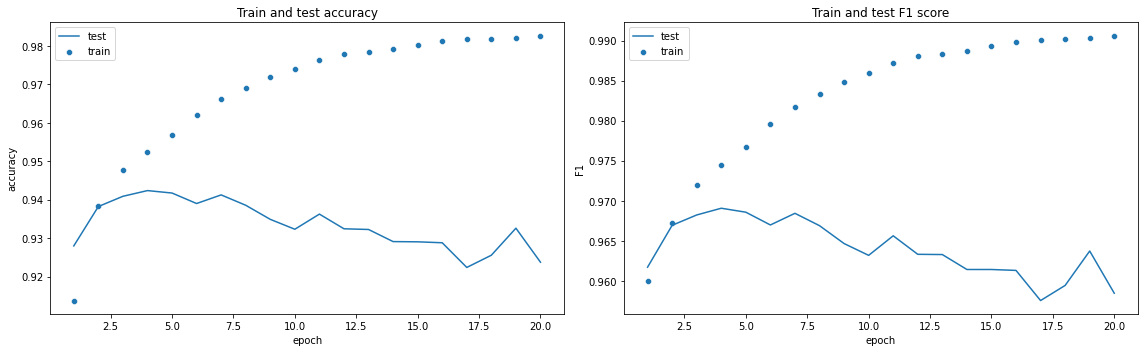

The highest accuracy score in 4 epoch: 0.942364
The highest f1 score in 4 epoch: 0.969061


In [21]:
model_report(history_conv)

## Model verification

LSTM model returned the best results: accuracy - 95,93%, f1-score - 0.9779. Let's take a look at the output given by this model.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9)

In [24]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics_definition)

model.fit(X_train, y_train,
          epochs=8,
          batch_size=128,
          validation_split=0.2,
          verbose=0)

In [25]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

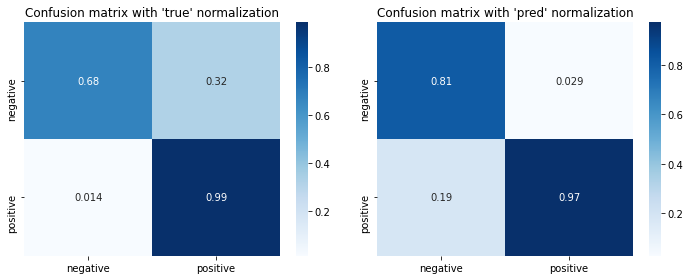

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
confusion_dict = {ax1: 'true', ax2: 'pred'}
labels = ['negative', 'positive']

for k, v in confusion_dict.items():
    cm = confusion_matrix(y_test, y_pred, normalize=v)
    sns.heatmap(cm,
                cmap=plt.cm.Blues,
                annot=True,
                xticklabels=labels,
                yticklabels=labels,
                ax=k)
    k.set_title('Confusion matrix with \'%s\' normalization' % v)
plt.tight_layout()
plt.show()

The model is very good at finding positive reviews - from all positive reviews, over 99% were assigned correct label. When it comes to negative reviews, the model assign correct label only in 61% of cases.

When we look at the predicted labels, from all positive labels, 97% are true positives and 3,5% are false positives. Among labels predicted as negative, 85% are true negatives and 15% are false negatives.

When comparing to Logistic Regression model we can see that the model has better results in assigning true negatives but it generates more false negatives at the same time. Despite this, model results are very similar to each other.

There is a trade-off between precision and recall and finding a balance between those two should be based on a business decision. It is important to have in mind a cost of false negatives and false positives. The output of LSTM model are probabilities - for this analysis the 0.5 threshold was used but changing it will enable adjusting precision - recall ratio to the business needs.